# Analysis2 - FiD Heatmap and Damaging Pasages
 - consequent analysis of Analysis - FiD Heatmap and Damaging Pasages
 - With Analysis Across Retrievers, Further analysis on damaging passages
 - Checking # of damaging passages @ K

# 1. Token Level Attention Score on Last Layer (Max)
    - Token Level Attention Score on the first decoded token on Last Layer

# 2. Token Level Attention Score on Last Layer (Min)
    - Token Level Attention Score on the first decoded token on Last Layer

In [1]:
from cycler import cycler
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pathlib
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import re
from util import utils
import os
from pathlib import Path
from sklearn.utils.extmath import softmax

In [2]:
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]


light_palette = np.array(raw_light_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255

Light mode palette


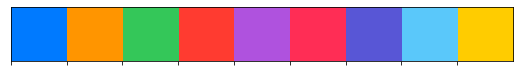

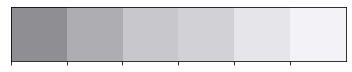

In [3]:
print('Light mode palette')
sns.palplot(light_palette)
sns.palplot(gray_light_palette)

In [4]:
# cmap 수정
mpl.rcParams['axes.prop_cycle'] = cycler('color',light_palette)
# 해상도 조정
mpl.rcParams['figure.dpi'] = 200
# ax의 우측과 상단 지우기
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
from IPython.display import Image

In [6]:
import pickle
import numpy as np
import pathlib
from pprint import pprint
import pandas as pd
from util import utils
import re
import os
from copy import deepcopy
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
from copy import deepcopy

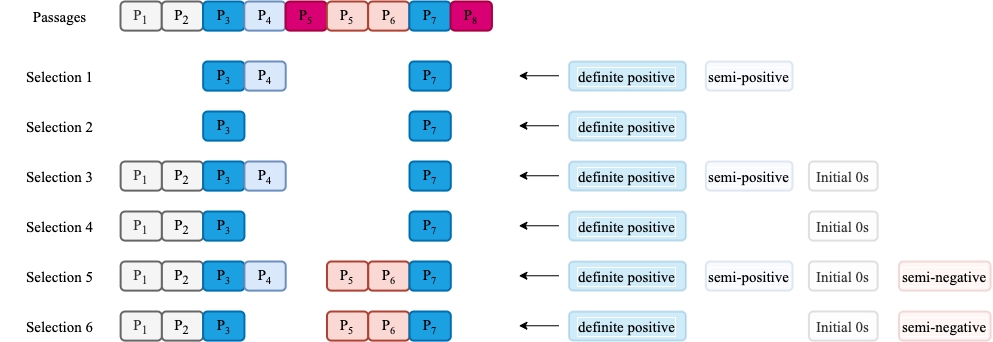

In [7]:
Image(filename='./img/selectionmethod2.drawio의 복사본.png', width=800)

| Dataset |  Retriever | Lower | Upper | Selection1 | Selection2 |              Selection3              | Selection4 | Selection5 | Selection6 |
|:-------:|:----------:|:-----:|:-----:|:----------:|:----------:|:------------------------------------:|:----------:|:----------:|:----------:|
|         | DPR        |  52.5 |  62.3 |    58.1    |    56.3    | 61.8 |    61.7    |    55.2    |    56.0    |
|         | SEAL       |  50.0 |  59.4 |    43.9    |    30.0    |             52.9         |    44.9    |    52.5    |    44.6    |
|    NQ   | Contriever |  50.7 |  60.8 |    44.3    |    29.0    |             53.0          |    45.1    |    52.6    |    44.4    |
|         | DPR        |  72.3 |  77.7 |    76.2    |    75.1    | 77.6 |    77.4    |    73.8    |    74.0    |
|         | SEAL       |  67.1 |  72.3 |    67.9    |    51.5    | 72.5     |    63.7    |    72.3    |    63.9    |
|   TQA   | Contriever |  69.7 |  75.5 |    68.4    |    51.7    |             72.5           |    62.9    |    72.3    |    62.9    |

## NQ TEST DPR 

In [8]:
# input_file = f'/data/philhoon-relevance/FiD/results/NQ_DPR/TEST/incremental_result_{sample_size}/ctx{sample_size}.json'
# output_path = f'/data/philhoon-relevance/FiD/open_domain_data/NQ_TEST_DPR_SELECTION_NEW/'

## NQ DEV DPR 

In [9]:
dataset = 'NQ'
retriever = 'DPR'
datatype = 'DEV'
sample_size = 100

## NQ DEV SEAL

In [10]:
# dataset = 'NQ'
# retriever = 'SEAL'
# datatype = 'DEV'
# sample_size = 100

## NQ DEV Contriever

In [11]:
# dataset = 'NQ'
# retriever = 'CONTRIEVER'
# datatype = 'DEV'
# sample_size = 100

## TQA TEST DPR 

In [12]:
# dataset = 'TQA'
# retriever = 'DPR'
# datatype = 'TEST'
# sample_size = 100

## TQA DEV DPR 

In [13]:
# dataset = 'TQA'
# retriever = 'DPR'
# datatype = 'DEV'
# sample_size = 100

## TQA DEV CONTRIEVER 

In [14]:
# dataset = 'TQA'
# retriever = 'CONTRIEVER'
# datatype = 'DEV'
# sample_size = 100

## TQA DEV SEAL 

In [15]:
# dataset = 'TQA'
# retriever = 'SEAL'
# datatype = 'DEV'
# sample_size = 100

In [16]:
input_file = f'/scratch/philhoon-relevance/FiD/results/{dataset}_{retriever}/{datatype}/incremental_result_{sample_size}/ctx{sample_size}.json'
print(input_file)

/scratch/philhoon-relevance/FiD/results/NQ_DPR/DEV/incremental_result_100/ctx100.json


In [17]:
# output_path = f'/scratch/philhoon-relevance/FiD/open_domain_data/{dataset}_{datatype}_{retriever}_SELECTION_NEW/'
# print(output_path)

In [18]:
print(input_file)
# print(output_path)

/scratch/philhoon-relevance/FiD/results/NQ_DPR/DEV/incremental_result_100/ctx100.json


## Count Damaging Passages

In [19]:
input_ = utils.open_json(input_file)

In [20]:
(input_[0].keys())

dict_keys(['question', 'answers', 'ctxs', 'em_pattern', 'inference', 'conversion', 'cumulative_em'])

In [21]:
# count # of queries having damaging passages @ K
def get_stats_at_k(input_, k):
    reg_AcEM =  r'.*1.*'
    reg_EM = r'.*1$'
    reg_d = r'.*10.*'

    cnt_AcEM = 0
    cnt_EM = 0
    cnt_d = 0

    for instance in input_:
        if re.match(reg_AcEM, instance['em_pattern'][:k]):
            cnt_AcEM += 1
        if re.match(reg_EM,instance['em_pattern'][:k]):
            cnt_EM += 1
        if re.match(reg_d, instance['em_pattern'][:k]):
            cnt_d += 1
    #         print(instance['em_pattern'][:k])
    print(f'# of AcEM@K : {cnt_AcEM}')
    print(f'# of EM@K : {cnt_EM}')
    print(f'# of damaging quries : {cnt_d}')
    print(f'# of AcEM@K - EM@K : {cnt_AcEM - cnt_EM}')
    print(f'# of total quries : {len(input_)}')
    print(f'EM@K : {cnt_EM/len(input_)}')
    print(f'AcEM@K : {cnt_AcEM/len(input_)}')
    
        

In [22]:
get_stats_at_k(input_, 20)

# of AcEM@K : 5089
# of EM@K : 4397
# of damaging quries : 1091
# of AcEM@K - EM@K : 692
# of total quries : 8757
EM@K : 0.5021125956377754
AcEM@K : 0.5811350919264588


In [23]:
def open_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [24]:
def merge(input_, attention_dict):
    new_input = deepcopy(input_)
    for index, instance in enumerate(new_input, 0):
        instance['attention_score'] = attention_dict[index]
    return new_input

In [25]:
# def np_softmax(x):
    
#     max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
#     e_x = np.exp(x - max) #subtracts each row with its max value
#     sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
#     f_x = e_x / sum 
#     return f_x

In [26]:
def get_heatmap(np_array_attention, x_tick_labels, answer):
    arr2 = np_array_attention
    mask = np.zeros_like(arr2)
    mask[np.triu_indices_from(mask, k = 1)] = True
#     print(x_tick_labels)
    y_tick_labels = range(1, len(x_tick_labels)+1)
    fig, ax = plt.subplots(1,1 ,figsize=(12, 12))
    sns.heatmap(arr2, ax=ax,
                center=0,
                annot=True, 
                fmt='.3f', # d
                cmap='coolwarm',
                linewidth=0.1, square=True,
                mask=mask,
                annot_kws={'size': 7},
                yticklabels = y_tick_labels,
                xticklabels = x_tick_labels
#                 xlabel = 'EM Pattern'
               )
    plt.xticks(fontsize=7, rotation=45, horizontalalignment='right')
    plt.xlabel(f'EM match : answer {answer}', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('# of passage', fontsize = 10) # y-axis label with fontsize 15
    plt.show()

In [27]:
def transform_to_np(index, input_attention, passage_size, option='softmax'):
    
    arr2 = np.full(shape=(passage_size, passage_size), fill_value=-9999, dtype=float)
    
    test = input_attention[index]['attention_score']
    answer = input_attention[index]['answers']
    
    x_tick_labels_lst = []
    for em_p, infer_ in zip(input_attention[index]['em_pattern'][:passage_size], input_attention[index]['inference'][:passage_size]):
        x_tick_label = f'{str(em_p)} \n {infer_}'
        x_tick_labels_lst.append(x_tick_label)
#     x_tick_labels = input_attention[index]['em_pattern'][:passage_size]
#     print(x_tick_labels_lst)
    for x_index, x_lst in enumerate(test[:passage_size], 0):
            for y_index, value in enumerate(x_lst, 0):
                arr2[x_index][y_index] = value
    if option == 'softmax':        
        arr2 = softmax(arr2)
    return arr2, x_tick_labels_lst, answer

In [28]:
# original
def get_attention_dict_orig(attention_path, option = 'max', option2='last'):
    attention_dict = defaultdict(list)
    for i in tqdm(range(1, 21)):
        attention_file = attention_path + f'NQ_dev_{i}_context/attention_score.pickle'
        data = open_pickle(attention_file)
        for ins in data:
            # get the attention score on the last layer first decoded token
            
            # last file differnt
            if option2 == 'last':
                score = ins['attention_score'][:, 0, :]
                
            # get the max attention score
            if option == 'max':
                attention_score = score.max(1).values
            elif option == 'min':
                attention_score = score.min(1).values
            else:
                attention_score = score.average(1).values
            attention_score_lst  = attention_score.tolist()        
            # id
            id_ = ins['id'].item()
            attention_dict[id_].append(attention_score_lst)
        del data
        
    return attention_dict

In [29]:
def get_attention_dict(attention_path, option1 = 'max', option2='last'):
    attention_dict = defaultdict(list)
    for i in tqdm(range(1, 21)):
        attention_file = attention_path + f'NQ_dev_{i}_context/attention_score.pickle'
        data = open_pickle(attention_file)
        for ins in data:
            # get the attention score on the last layer first decoded token
            # last file differnt
            if option2 == 'last':
                score = ins['attention_score'][:, 0, -1, :]
            elif option2 == 'first':
                score = ins['attention_score'][:, 0, 0, :]
                
            # get the max attention score
            if option1 == 'max':
                attention_score = score.max(1).values
            elif option1 == 'min':
                attention_score = score.min(1).values
            else:
                attention_score = score.average(1).values
            attention_score_lst  = attention_score.tolist()        
            # id
            id_ = ins['id'].item()
            attention_dict[id_].append(attention_score_lst)
        del data
        
    return attention_dict

In [30]:
def get_definite_pos_neg(test_em):
    positive_pos = []
    if test_em.startswith('1'):
        positive_pos.append(0)
    iter_ = re.finditer(r'01', test_em)
    for m in iter_:
        pos_ = m.start() + 1
        positive_pos.append(pos_)

    negative_pos = []
    iter_ = re.finditer(r'10', test_em)
    for m in iter_:
        pos_ = m.start() + 1
        negative_pos.append(pos_)
    
    return positive_pos, negative_pos

In [31]:
def get_distplot(atten_def_pos, atten_def_neg, atten_rest):
    fig, ax = plt.subplots(1,1 ,figsize=(10, 9))
    sns.histplot(atten_def_pos, ax = ax, label='def_pos')
    sns.histplot(atten_def_neg, ax = ax, label='def_neg')
    sns.histplot(atten_rest, ax = ax, label='rest')
    plt.legend()
    plt.show()
    

In [32]:
# k = np.array(attention_max_data[3]['attention_score'][passage_size-1])

In [33]:
# k2 = k[None,:]

In [34]:
# k3 = softmax(k2)

In [35]:
# k3.shape[0]

In [36]:
# k3[0,0]

In [37]:
def get_attention_defpos_defneg_rest(input_attention, passage_size):
    def_pos_attention_score_lst = []
    def_neg_attention_score_lst = []
    def_rest_lst = []
    for instance in input_attention:
        pos_, neg_ = get_definite_pos_neg(instance['em_pattern'][:passage_size])
        attention_ = np.array(instance['attention_score'][passage_size-1])
        attention_ = attention_[None, :]
        attention_softmax_ = softmax(attention_)
        
        if attention_softmax_.shape[0] != 1:
            print('Wrong outcome')
            break
        
        for index_ in range(0, passage_size):
            if index_ in pos_:
                def_pos_attention_score_lst.append(attention_softmax_[0, index_])
            elif index_ in neg_:
                def_neg_attention_score_lst.append(attention_softmax_[0, index_])
            else:
                def_rest_lst.append(attention_softmax_[0, index_])

    return def_pos_attention_score_lst, def_neg_attention_score_lst, def_rest_lst

# 1. Token Level Attention Score on Last Layer (Max)

In [38]:
attention_path = f'/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN/'
print(attention_path)

/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN/


In [39]:
# attention_max = get_attention_dict_orig(attention_path, 'max')

In [40]:
attention_max_first_filename = '/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN/atten_max_last.pickle'

In [41]:
# with open(attention_max_first_filename, 'wb') as f:
#     pickle.dump(attention_max, f, pickle.HIGHEST_PROTOCOL)

In [42]:
attention_max = open_pickle(attention_max_first_filename)

In [43]:
attention_max_data = merge(input_, attention_max)

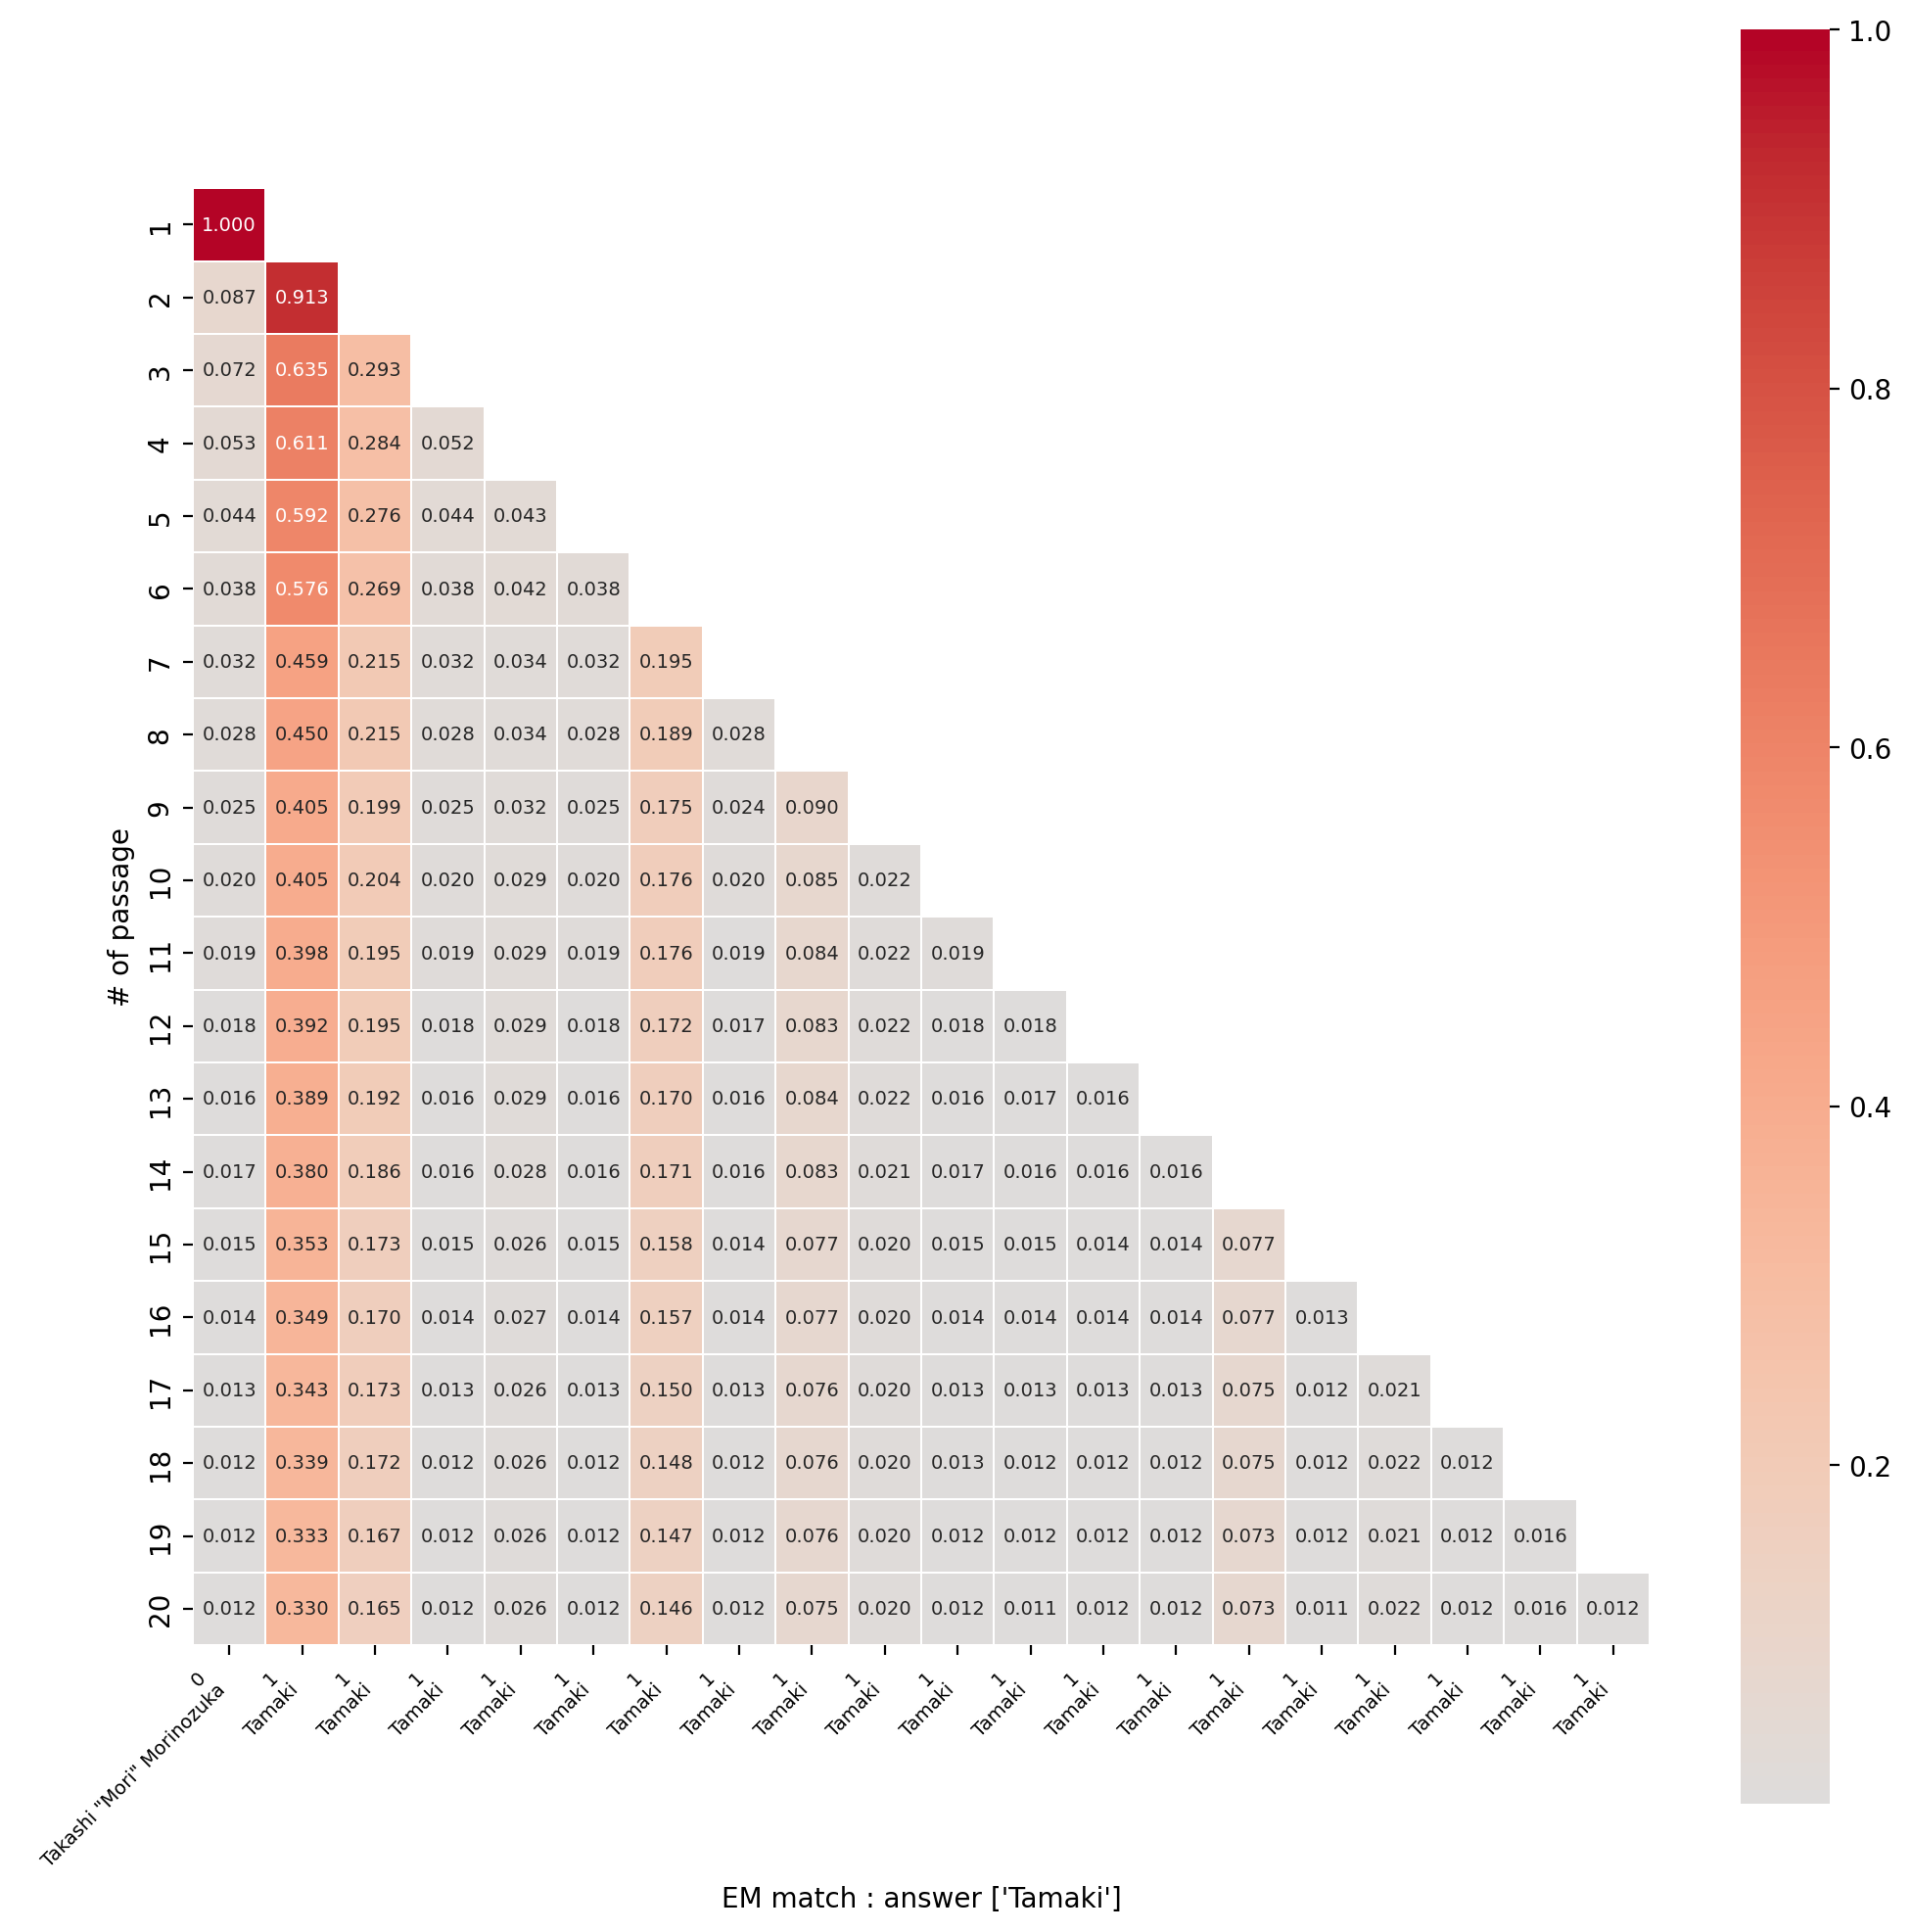

In [46]:
index = 100
passage_size = 20
option = 'softmax'
last_np_array_attention, x_tick_labels, answer = transform_to_np(index, attention_max_data, passage_size, option)
get_heatmap(last_np_array_attention, x_tick_labels, answer)

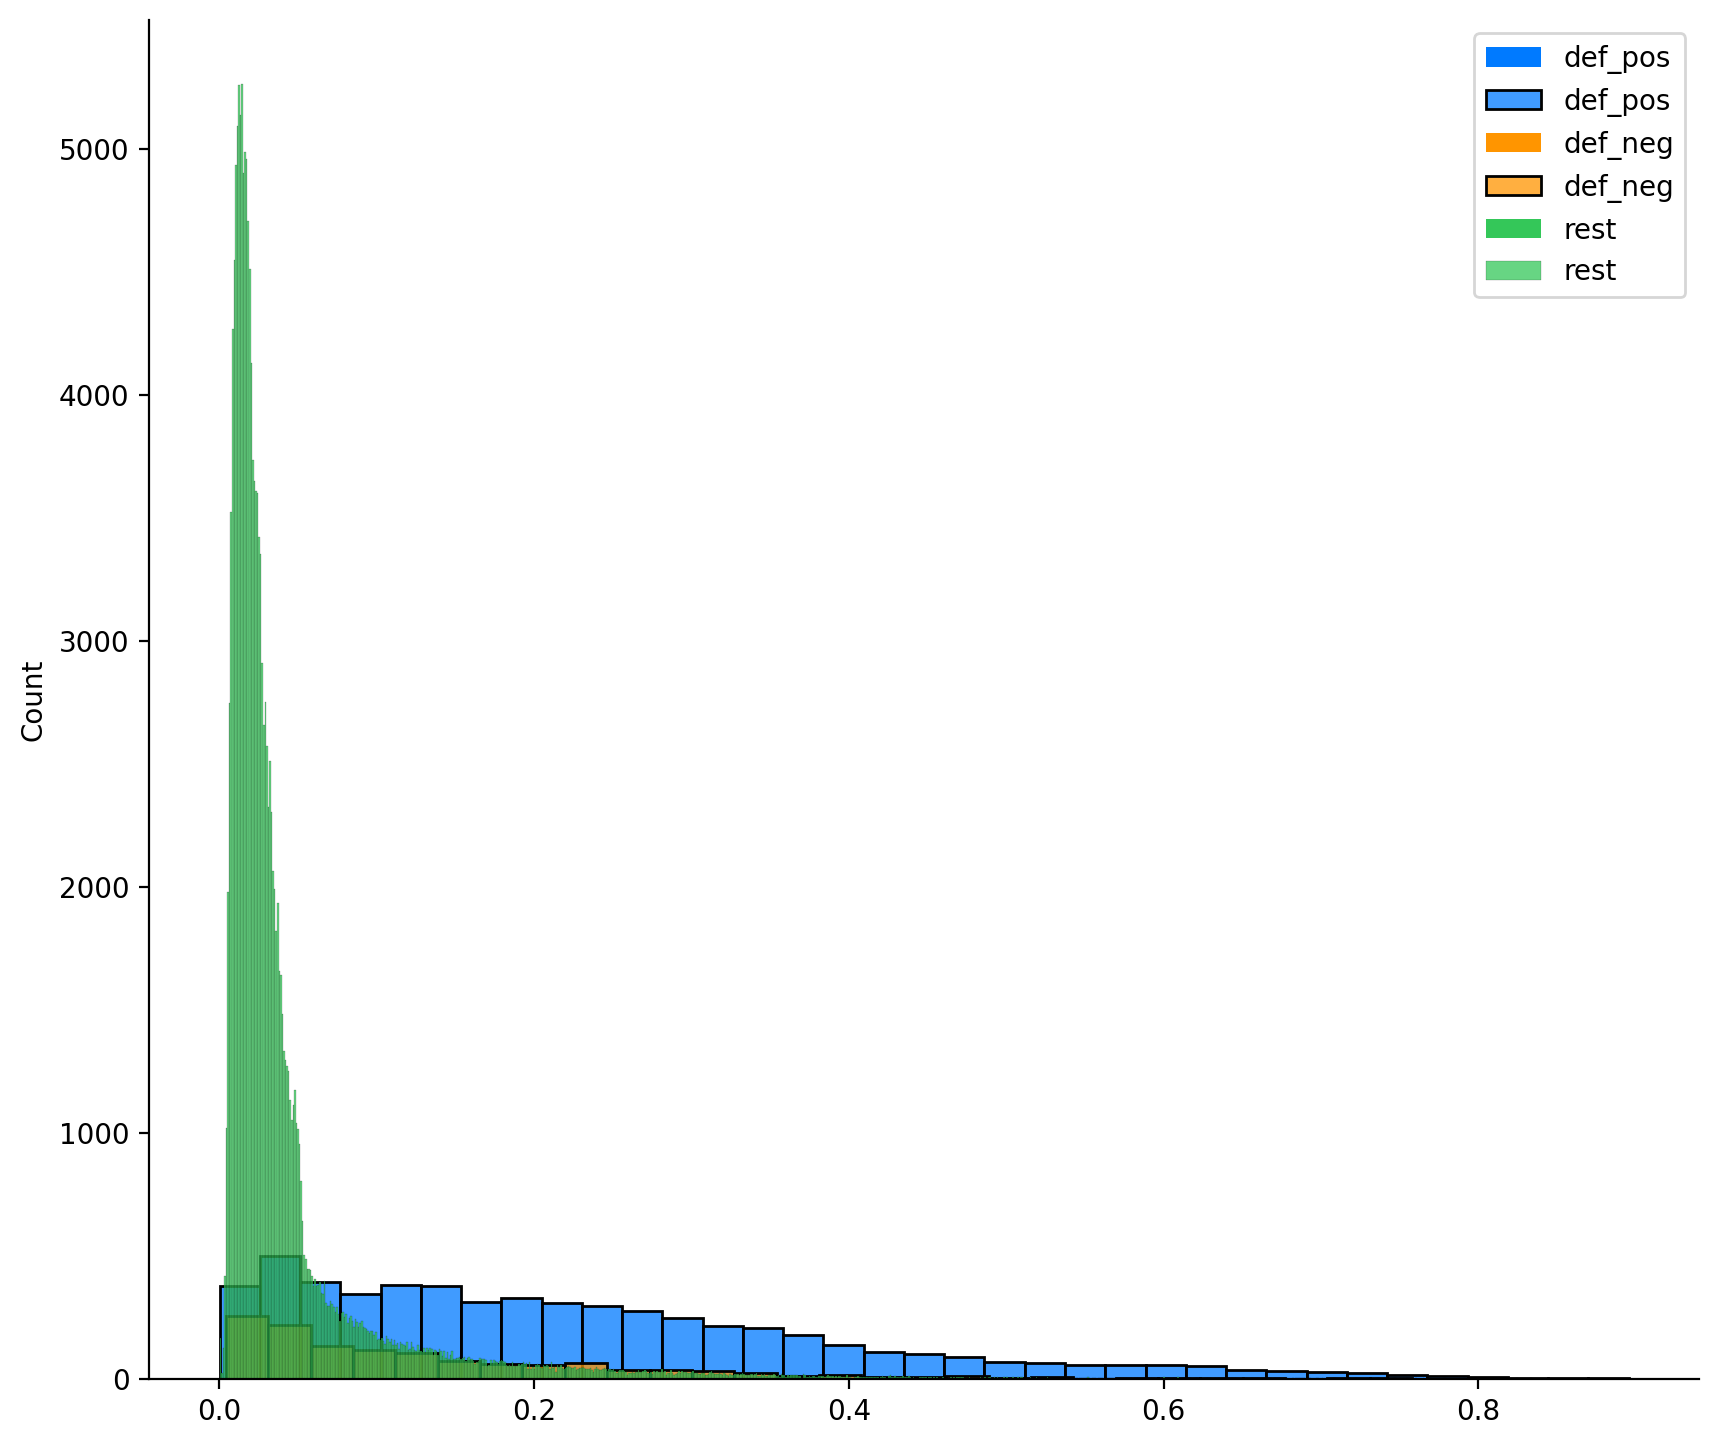

In [47]:
last_atten_def_pos, last_atten_def_neg, last_atten_rest = get_attention_defpos_defneg_rest(attention_max_data, passage_size)
get_distplot(last_atten_def_pos, last_atten_def_neg,  last_atten_rest)

## Max 
### Argument1
    Generally when there is a conversion, there is a spike in attention score
    with few exceptions : index 10, 75, 76, 78, 1009
    
### Argument2
    The converse of Arugment1 is not true. That is attention spike does not guarantee the conversion
    
### Argument3
    Attention Spike possibly happen outside the conversion
        -> give more attentions to more plausible passages for inference
        
### Argument4
    01 Conviersion which are definite positives have high attention scores usually compared to defnite negative, and the rest of passage
  

## Result - removing passages by attention max score

| Attention Score | Exact Match |
| --- | ---  |
| AcEM@20 |  58.11 |
| EM@20 (FiD w/ 20 psgs) |  50.21 |
| 0.025 |  49.5 |
| 0.05 |  49.11 |
| 0.075 |  48.30 |
| 0.1 |  47.55 |
| 0.2 |  46.59 |



# 2. Token Level Attention Score on First Layer (Max)

In [48]:
attention_path = '/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN_LAYERS/'
print(attention_path)

/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN_LAYERS/


In [50]:
# attention_max_first = get_attention_dict(attention_path, option1 = 'max', option2 = 'first')

In [51]:
attention_max_first_filename = '/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN_LAYERS/atten_max_first.pickle'

In [52]:
# with open(attention_max_first_filename, 'wb') as f:
#     pickle.dump(attention_max_first, f, pickle.HIGHEST_PROTOCOL)

In [56]:
attention_max_first = open_pickle(attention_max_first_filename)

In [57]:
attention_max_first_data = merge(input_, attention_max_first)

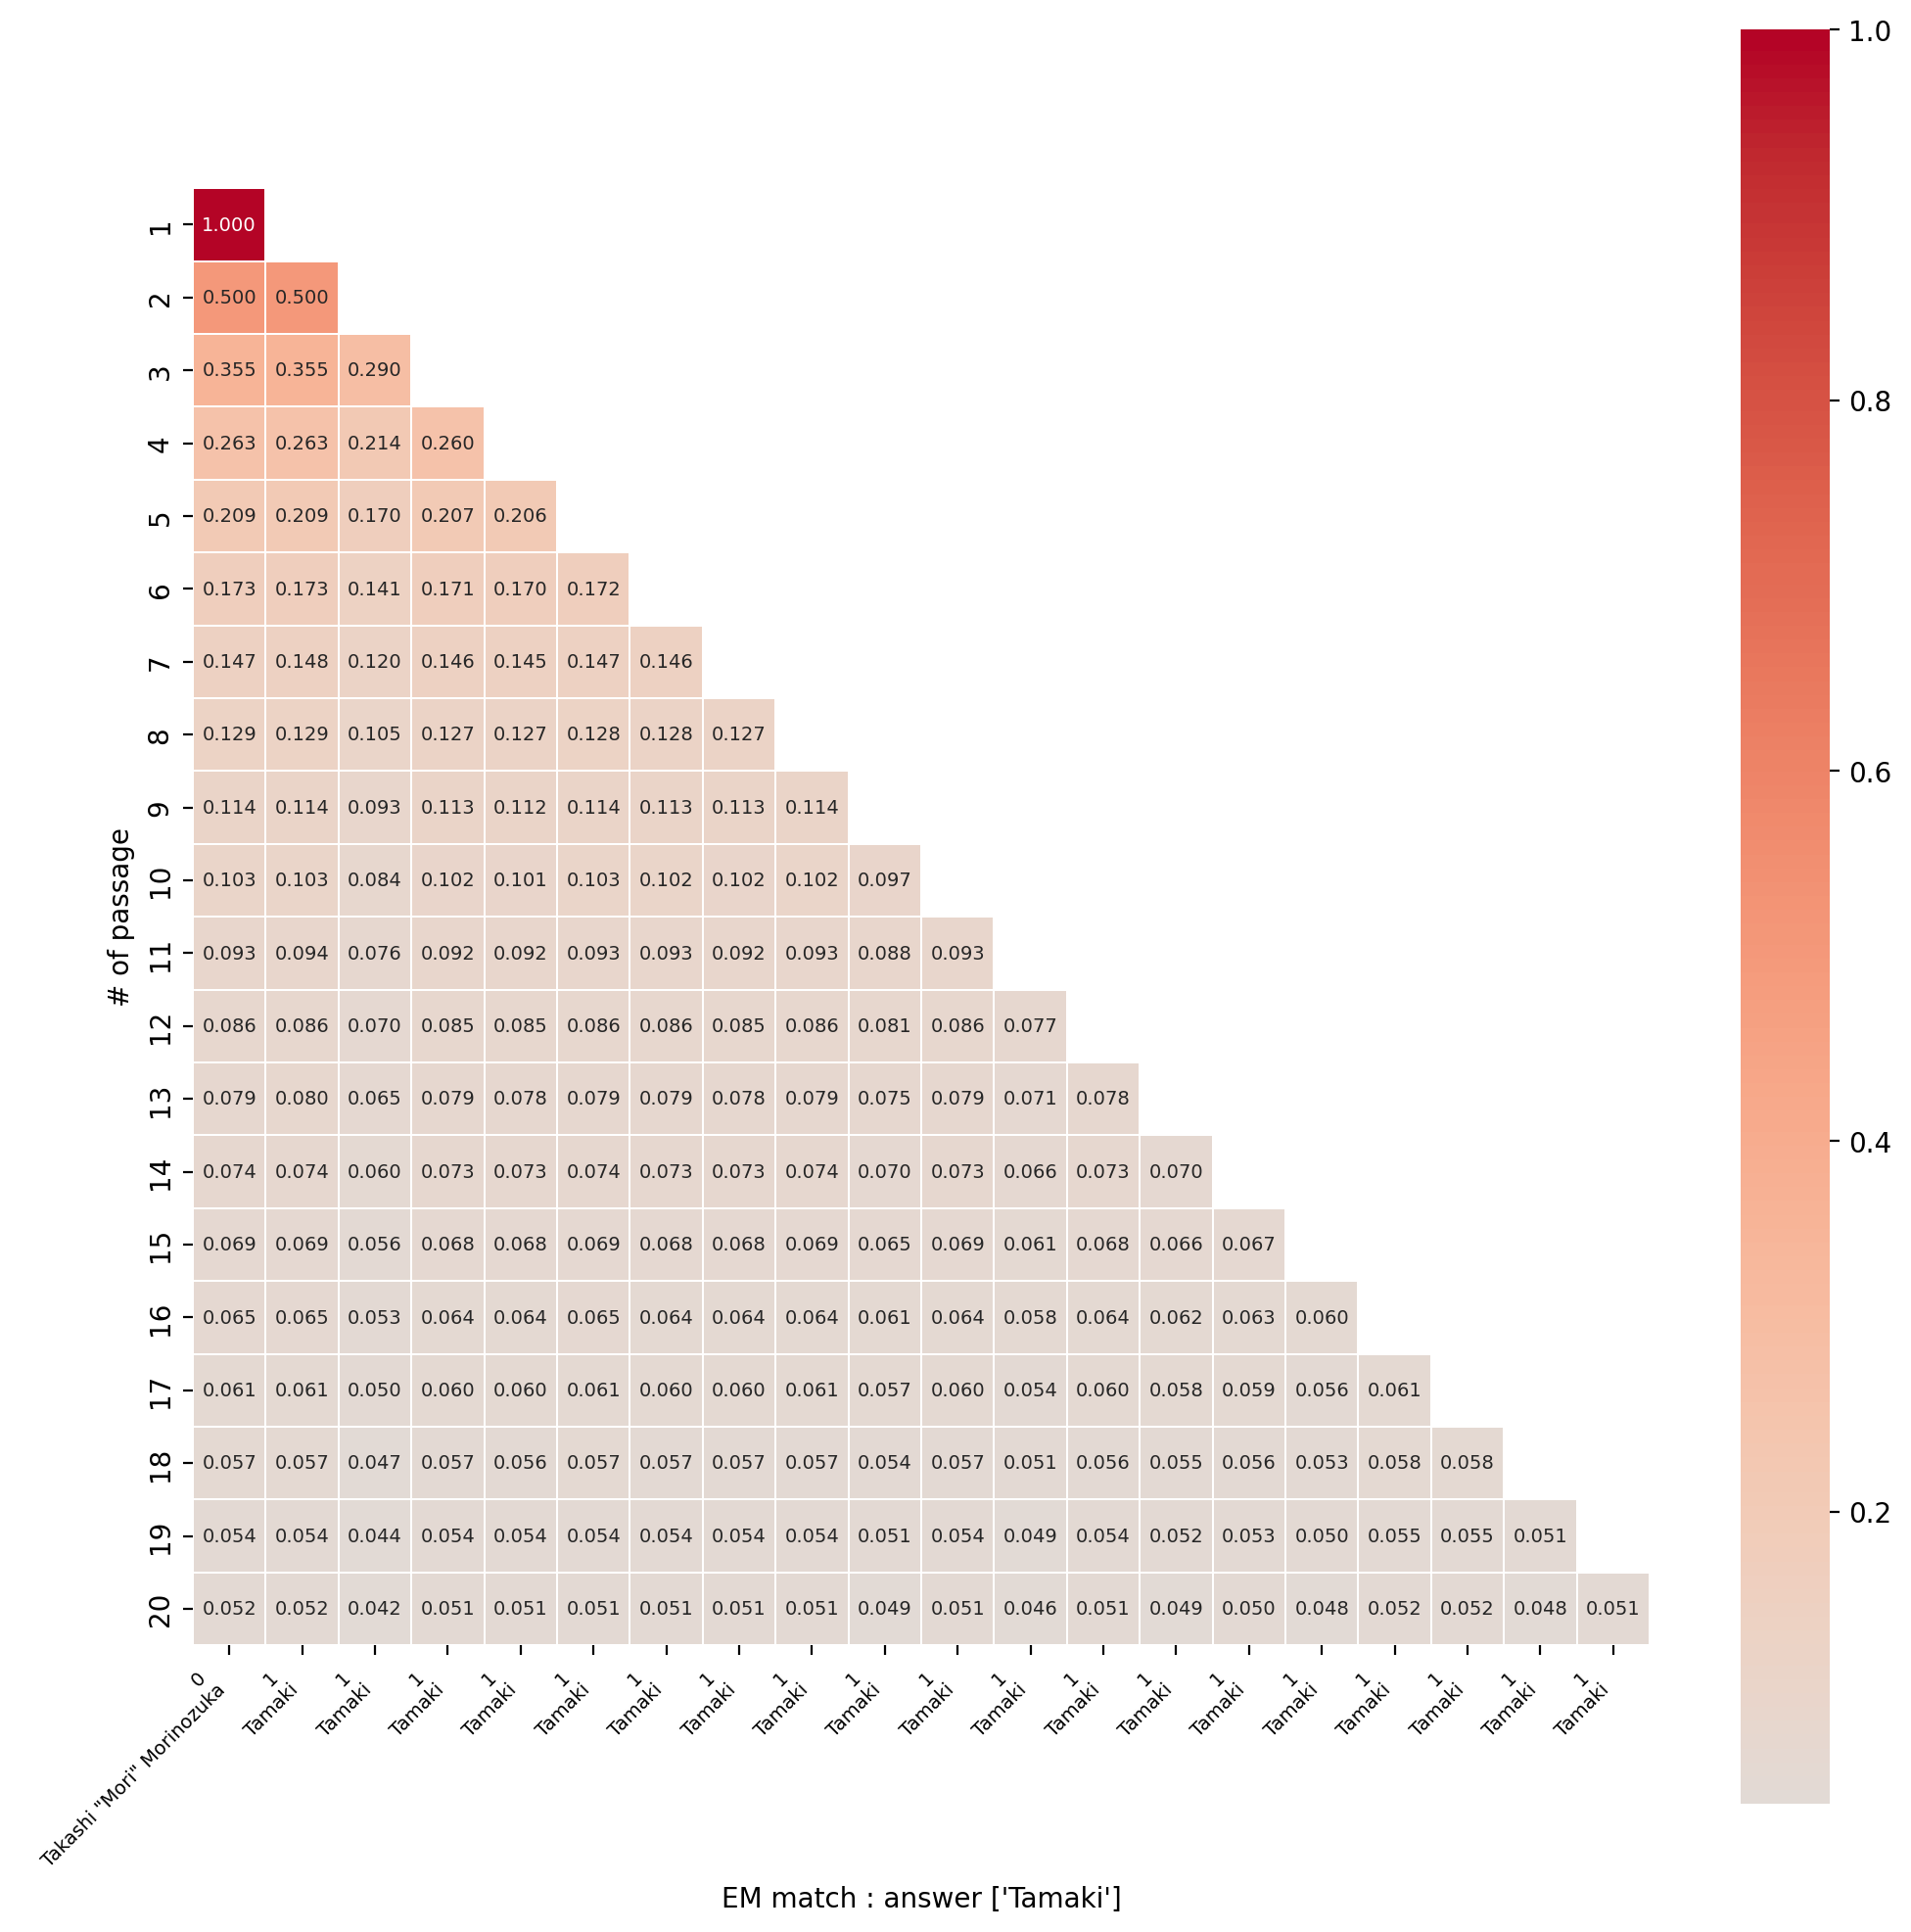

In [59]:
index = 100
passage_size = 20
option = 'softmax'
first_np_array_attention, x_tick_labels, answer = transform_to_np(index, attention_max_first_data, passage_size, option)
get_heatmap(first_np_array_attention, x_tick_labels, answer)

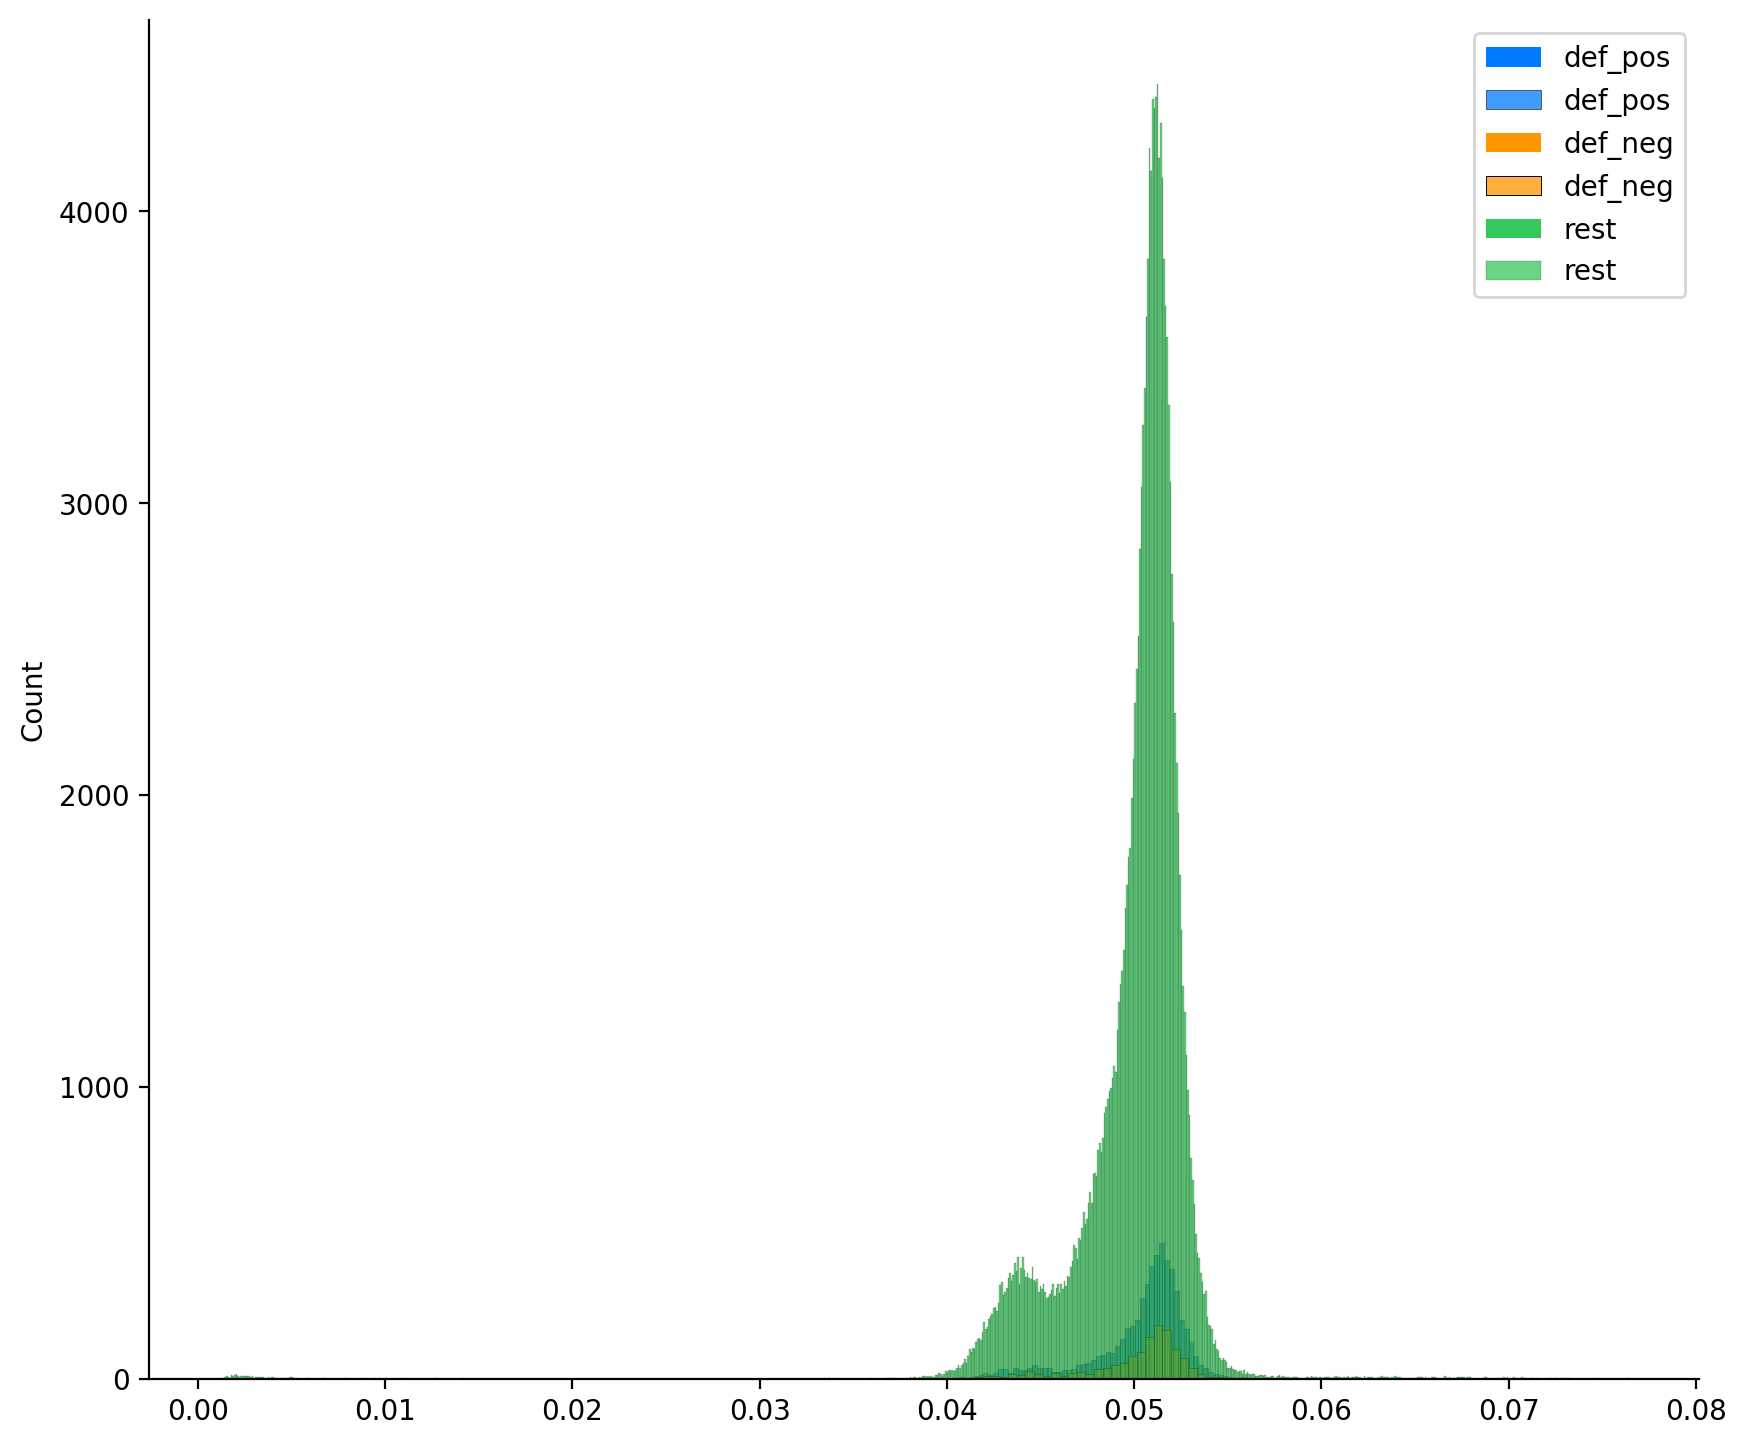

In [60]:
last_atten_def_pos, last_atten_def_neg, last_atten_rest = get_attention_defpos_defneg_rest(attention_max_first_data, passage_size)
get_distplot(last_atten_def_pos, last_atten_def_neg,  last_atten_rest)

# 3. Token Level Attention Score on Last Layer (Min)

In [ ]:
attention_min = get_attention_dict(attention_path, 'min')

In [ ]:
attention_min_data = merge(input_, attention_min)

In [ ]:
index = 1000
passage_size = 20
option = 'softmax'
min_np_array_attention, x_tick_labels, answer = transform_to_np(index, attention_min_data, passage_size, option)
get_heatmap(min_np_array_attention, x_tick_labels, answer)

In [ ]:
last_atten_def_pos, last_atten_def_neg, last_atten_rest = get_attention_defpos_defneg_rest(attention_min_data, passage_size)
get_distplot(last_atten_def_pos, last_atten_def_neg,  last_atten_rest)

# 3. Token Level Attention Score on First Layer (Max)

In [ ]:
attention_max_data = merge(input_, attention_max)

In [ ]:
def get_attention_defpos_defneg(input_attention, passage_size):
    def_pos_attention_score_lst = []
    def_neg_attention_score_lst = []
    for instance in input_attention:
        pos_, neg_ = get_definite_pos_neg(instance['em_pattern'][:passage_size])
        if pos_:
            for p_ in pos_:
                def_pos_attention_score_lst.append(instance['attention_score'][p_][-1])
        if neg_:
            for n_ in neg_:
                def_neg_attention_score_lst.append(instance['attention_score'][n_][-1])
    return def_pos_attention_score_lst, def_neg_attention_score_lst

In [ ]:
atten_def_pos, atten_def_neg = get_attention_defpos_defneg(input_attention, passage_size)

In [ ]:
# input_attention[0]['attention_score'][:passage_size]

In [ ]:
print(len(atten_def_pos))
print(len(atten_def_neg))

In [ ]:
def get_distplot(atten_def_pos, atten_def_neg):
    fig, ax = plt.subplots(1,1 ,figsize=(10, 9))
    sns.histplot(atten_def_pos, ax = ax, label='def_pos')
    sns.histplot(atten_def_neg, ax = ax, label='def_neg')
    plt.legend()
    plt.show()
    

In [ ]:
get_distplot(atten_def_pos, atten_def_neg)

## Mahn-Whitney Test (Wilcoxon Rank Sum Test)

    - non-parametric method for comparing distrutions of two data
    - null hypothesis : Two groups have the same distributions
    - alternaive hypothesis : Two groups do not have the same distributions

In [ ]:
from scipy.stats import ranksums
from scipy.stats import kruskal

In [ ]:
def get_ranksum(atten_def_pos, atten_def_neg):
    result = ranksums(atten_def_pos, atten_def_neg, alternative='two-sided')
    return result

In [ ]:
result = get_ranksum(atten_def_pos, atten_def_neg)

In [ ]:
print(result)

# 2. Passage Level Attention Score on Last Layer

In [ ]:
# path_attention_score_last = '/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN'

In [ ]:
# i = 2
# path = f'/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN/NQ_dev_{i}_context/attention_score.pickle'

In [ ]:
def open_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
# data = open_pickle(path)

In [ ]:
attention_dict_last_layer = defaultdict(list)
for i in tqdm(range(1, 21)):
    attention_file = f'/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN/NQ_dev_{i}_context/attention_score.pickle'
    data = open_pickle(attention_file)
    for ins in data:
        # get the attention score on the last layer first decoded token
        score = ins['attention_score'][:, 0, :]
        attention_score = score.mean(1)
        attention_score_lst  = attention_score.tolist()

        # id
        id_ = ins['id'].item()
        attention_dict_last_layer[id_].append(attention_score_lst)


In [ ]:
# attention_dict[0]

In [ ]:
# for ins in data:
#     print(ins['attention_score'].shape)

In [ ]:
# data[0]['id']

In [ ]:
# # n_contexts, decoded token, passages length
# data[200]['attention_score'].shape

In [ ]:
# # first decoded token 
# score = data[0]['attention_score'][:, 0, :]

In [ ]:
# score.shape

In [ ]:
# average = score.mean(1)

In [ ]:
# average.shape

In [ ]:
# attention_dict = defaultdict(list)
# for i in tqdm(range(1, 21)):
#     attention_file = f'/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN/NQ_dev_{i}_context/attention_score.pickle'
#     attention_input_ = open_pickle(attention_file)
#     print(len(attention_input_))
#     print(attention_input_[0]['attention_score'].shape)
    
# #     for instance in attention_input_:
# #         attention_score_lst = get_attention_score(i, instance['ctxs'])
#         attention_dict[instance['id']].append(attention_score_lst)

## Merging

In [ ]:
input_attention_last_layer = merge(input_, attention_dict_last_layer)

In [ ]:
print(input_attention_last_layer[0].keys())

In [ ]:
# damaging index : 8, 21, 35
index = 7
passage_size = 20
option = 'softmax'
last_np_array_attention, x_tick_labels = transform_to_np(index, input_attention_last_layer, passage_size, option)
get_heatmap(last_np_array_attention, x_tick_labels)

In [ ]:
last_atten_def_pos, last_atten_def_neg = get_attention_defpos_defneg(input_attention_last_layer, passage_size)

In [ ]:
get_distplot(last_atten_def_pos, last_atten_def_neg)

In [ ]:
def get_ranksum(atten_def_pos, atten_def_neg):
    result = ranksums(atten_def_pos, atten_def_neg, alternative='two-sided')
    return result

In [ ]:
result = get_ranksum(last_atten_def_pos, last_atten_def_neg)

In [ ]:
print(result)

## Max 
### Argument1
    When there is a conversion, there is a spike in attention score
    with few exceptions : index 10, 75, 76, 78
    
### Arguement2
    The converse of Arugment1 is not true. That is attention spike does not guarantee the conversion
    
### Argument3
    Attention Spike possibly happen outside the conversion
        -> give more attentions to more plausible passages for inference

In [ ]:
attention_dict_last_layer_max = defaultdict(list)
for i in tqdm(range(1, 21)):
    attention_file = f'/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT_TOKEN/NQ_dev_{i}_context/attention_score.pickle'
    data = open_pickle(attention_file)
    for ins in data:
        # get the attention score on the last layer first decoded token
        score = ins['attention_score'][:, 0, :]
        attention_score = score.max(1).values
#         print(attention_score)
        attention_score_lst  = attention_score.tolist()

        # id
        id_ = ins['id'].item()
        attention_dict_last_layer_max[id_].append(attention_score_lst)


In [ ]:
input_attention_last_layer_max = merge(input_, attention_dict_last_layer_max)

In [ ]:
print(input_attention_last_layer_max[0].keys())

In [ ]:
def get_heatmap_infer(np_array_attention, x_tick_labels, answer):
    arr2 = np_array_attention
    mask = np.zeros_like(arr2)
    mask[np.triu_indices_from(mask, k = 1)] = True
#     print(x_tick_labels)
    y_tick_labels = range(1, len(x_tick_labels)+1)
    fig, ax = plt.subplots(1,1 ,figsize=(12, 12))
    sns.heatmap(arr2, ax=ax,
                center=0,
                annot=True, 
                fmt='.3f', # d
                cmap='coolwarm',
                linewidth=0.1, square=True,
                mask=mask,
                annot_kws={'size': 7},
                yticklabels = y_tick_labels,
                xticklabels = x_tick_labels
#                 xlabel = 'EM Pattern'
               )
    plt.xticks(fontsize=7, rotation=45, horizontalalignment='right')
    plt.xlabel(f'EM match : answer {answer}', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('# of passage', fontsize = 10) # y-axis label with fontsize 15
    plt.show()

In [ ]:
def transform_to_np_infer(index, input_attention, passage_size, option='softmax'):
    
    arr2 = np.full(shape=(passage_size, passage_size), fill_value=-9999, dtype=float)
    
    test = input_attention[index]['attention_score']
    answer = input_attention[index]['answers']
    
    x_tick_labels_lst = []
    for em_p, infer_ in zip(input_attention[index]['em_pattern'][:passage_size], input_attention[index]['inference'][:passage_size]):
        x_tick_label = f'{str(em_p)} \n {infer_}'
        x_tick_labels_lst.append(x_tick_label)
#     x_tick_labels = input_attention[index]['em_pattern'][:passage_size]
    print(x_tick_labels_lst)
    for x_index, x_lst in enumerate(test[:passage_size], 0):
            for y_index, value in enumerate(x_lst, 0):
                arr2[x_index][y_index] = value
    if option == 'softmax':        
        arr2 = np_softmax(arr2)
    return arr2, x_tick_labels_lst, answer

In [ ]:
# damaging index : 7, 8, 14, 38, 50, 70, 90
# 10
# 14
index = 78
passage_size = 20
option = 'softmax'
last_np_array_attention, x_tick_labels, answer = transform_to_np_infer(index, input_attention_last_layer_max, passage_size, option)
get_heatmap_infer(last_np_array_attention, x_tick_labels, answer)

In [ ]:
last_atten_def_pos, last_atten_def_neg = get_attention_defpos_defneg(input_attention_last_layer_max, passage_size)

In [ ]:
def get_distplot_2(atten_def_pos, atten_def_neg, atten_rest):
    fig, ax = plt.subplots(1,1 ,figsize=(10, 9))
    sns.histplot(atten_def_pos, ax = ax, label='def_pos')
    sns.histplot(atten_def_neg, ax = ax, label='def_neg')
    sns.histplot(atten_rest, ax = ax, label='rest')
    plt.legend()
    plt.show()
    

In [ ]:
# input_attention_last_layer_max[0]['attention_score']

In [ ]:
def get_attention_defpos_defneg_rest(input_attention, passage_size):
    def_pos_attention_score_lst = []
    def_neg_attention_score_lst = []
    def_rest_lst = []
    for instance in input_attention:
        pos_, neg_ = get_definite_pos_neg(instance['em_pattern'][:passage_size])
        for index_ in range(0, passage_size):
            if index_ in pos_:
                def_pos_attention_score_lst.append(instance['attention_score'][index_][-1])
            elif index_ in neg_:
                def_neg_attention_score_lst.append(instance['attention_score'][index_][-1])
            else:
                def_rest_lst.append(instance['attention_score'][index_][-1])

    return def_pos_attention_score_lst, def_neg_attention_score_lst, def_rest_lst

In [ ]:
get_distplot(last_atten_def_pos, last_atten_def_neg)

## Min 
### Argument1
    When there is a conversion, there is a spike in attention score
    with few exceptions : index 10, 75, 76, 78
    
### Arguement2
    The converse of Arugment1 is not true. That is attention spike does not guarantee the conversion
    
### Argument3
    Attention Spike possibly happen outside the conversion
        -> give more attentions to more plausible passages for inference

==================================================================

In [ ]:
## Min-Max Average
### Argument1
    When there is a conversion, there is a spike in attention score
    with few exceptions : index 10, 75, 76, 78
    
### Arguement2
    The converse of Arugment1 is not true. That is attention spike does not guarantee the conversion
    
### Argument3
    Attention Spike possibly happen outside the conversion
        -> give more attentions to more plausible passages for inference

In [ ]:
attention_input_[0].keys()

In [ ]:
attention_input_[0]['question']

In [ ]:
attention_input_[0]['id']

In [ ]:
attention_input_[0]['ctxs']

In [ ]:
# path = pathlib.Path(attention_path)
# files = path.glob('**/final_output.txt')
# check_lst = list(files)
# pprint(check_lst)

In [ ]:
attention_file = f'/data/philhoon-relevance/FiD/results/NQ_DPR/DEV_ATT/NQ_dev__context/dataset_wscores.json'

In [ ]:
attention_input_ = utils.open_json(attention_file)

In [ ]:
attention_input_[0].keys()

In [ ]:
def check_inference(answer_lst, inference):
    try:
        inference = inference.lower()
    except:
        # making float nan -> str nan
        inference = str(inference).lower()
    
    for answer in answer_lst:
        answer = answer.lower()
        if inference == answer:
            return 1
    return 0

In [ ]:
cal_right = 0
cal_right_atten_lst = []
cal_wrong = 0
cal_wrong_atten_lst = []
for i in range(len(attention_input_)):
#     if input_[i]['inference'][0] == input_[i]['answers']:
    if check_inference(input_[i]['answers'], input_[i]['inference'][0]):
        cal_right += 1
        cal_right_atten_lst.append(attention_input_[i]['ctxs'][0]['score'])
    else:
        cal_wrong += 1
        cal_wrong_atten_lst.append(attention_input_[i]['ctxs'][0]['score'])
#     if i == 10:
#         break

In [ ]:
# cal_right_atten_lst

In [ ]:
# cal_wrong_atten_lst

In [ ]:
cal_right

In [ ]:
cal_wrong

In [ ]:
attention_input_[1]['ctxs'][0]

In [ ]:
print(input_[1]['inference'][0])
print(input_[1]['answers'])


# Damaging Passage Analysis Module

In [ ]:
def get_definite_pos_neg(test_em):
    positive_pos = []
    if test_em.startswith('1'):
        positive_pos.append(0)
    iter_ = re.finditer(r'01', test_em)
    for m in iter_:
        pos_ = m.start() + 1
        positive_pos.append(pos_)

    negative_pos = []
    iter_ = re.finditer(r'10', test_em)
    for m in iter_:
        pos_ = m.start() + 1
        negative_pos.append(pos_)
    
    return positive_pos, negative_pos

In [ ]:
def get_semi_pos(test_em):
    semi_pos = []
    iter_ = re.finditer(r'(?=(11))', test_em)
    for m in iter_:
        semi_pos_ = m.start() + 1
        semi_pos.append(semi_pos_)
    
    return semi_pos

def get_semi_neg(test_em, num_undecisive):
    semi_neg = []
    test_em_temp = test_em[num_undecisive:]
    iter_ = re.finditer(r'(?=(00))', test_em_temp)
    for m in iter_:
        semi_neg_ = m.start() + 1
        semi_neg.append(semi_neg_)
    semi_neg = [i + num_undecisive for i in semi_neg]
    return semi_neg

In [ ]:
input_[0].keys()

In [ ]:
input_file = input_

In [ ]:
def get_analysis_data(input_file, method):

    output_format = []

    for id_, instance in enumerate(input_file, 1):
        template_dict = {}
        if 'id' in instance.keys():
            template_dict['id'] = instance['id']
        else:
            template_dict['id'] = str(id_)

        template_dict['question'] = instance['question']
        template_dict['answers'] = instance['answers']
        template_dict['original_ctxs'] = instance['ctxs']
        template_dict['em_pattern'] = instance['em_pattern']
        template_dict['inference'] = instance['inference']
        template_dict['conversion'] = instance['conversion']
        template_dict['cumulative_em'] = instance['cumulative_em']

        em_pattern = deepcopy(instance['em_pattern'])
        instances_ = deepcopy(instance['ctxs'])
        num_undecisive = len(em_pattern) - len(em_pattern.lstrip('0'))


        # Meaing no EM
        if num_undecisive == 100:
            template_dict['ctxs']= instance['ctxs']
            output_format.append(template_dict)
        # Meaning EM
        else:
            # initial zeros
            new_context = []
            initial_zeros_lst = [i for i in range(0, num_undecisive)]

            # defnitie positive, definite negative
            defnite_positve_lst, defnite_negative_lst = get_definite_pos_neg(em_pattern)

            # semi positive, semi negative
            semi_positive_lst = get_semi_pos(em_pattern)
            semi_negative_lst = get_semi_neg(em_pattern, num_undecisive)

            if method == 'method1':
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)

            elif method == 'method2':
                new_context.extend(defnite_positve_lst)

            elif method == 'method3':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)

            elif method == 'method4':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)

            elif method == 'method5':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)
                new_context.extend(semi_negative_lst)

            elif method == 'method6':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_negative_lst)

            elif method == 'pos_analysis':
                new_context.extend(defnite_positve_lst)
            
                if [item for item, count in collections.Counter(new_context).items() if count > 1]:
                    print('Duplicates index!')
                else:
                    new_context_lst = [instances_[i]for i in new_context]                
                template_dict['index_pos_neg'] = new_context
                template_dict['ctxs'] = new_context_lst

            elif method == 'neg_analysis':
                new_context.extend(defnite_negative_lst)
            
                if [item for item, count in collections.Counter(new_context).items() if count > 1]:
                    print('Duplicates index!')
                else:
                    new_context_lst = [instances_[i]for i in new_context]
            
                template_dict['index_pos_neg'] = new_context
                template_dict['ctxs'] = new_context_lst
                
            output_format.append(template_dict)
    
    return output_format

#             if defnite_positve_lst and defnite_negative_lst:
#                 print(f"em_pattern : {instance['em_pattern']}")
#                 print(f"answer : {instance['question']}")
#                 print(f"answer : {instance['answers']}")
#                 print(f"defnite_positve_lst : {defnite_positve_lst}")
#                 pprint([instance['inference'][i]for i in defnite_positve_lst])
#                 pprint([instances_[i]for i in defnite_positve_lst])
#                 print(f"defnite_negative_lst : {defnite_negative_lst}")
#                 pprint([instance['inference'][i]for i in defnite_negative_lst])
#                 pprint([instances_[i]for i in defnite_negative_lst])


In [ ]:
pos_data = get_analysis_data(input_file, 'pos_analysis')
neg_data = get_analysis_data(input_file, 'neg_analysis')

In [ ]:
print(len(pos_data))
print(len(neg_data))

In [ ]:
# random.seed(42)
# n = 100
# query_id_lst = random.sample(range(0, len(pos_data)), n)

In [ ]:
# query_id_lst

In [ ]:
# pos_data[0].keys()

In [ ]:
# from pprint import pprint

In [ ]:
# print(pos_data[1824]['inference'])
# print(pos_data[1824]['em_pattern'])

In [ ]:
# print(pos_data[409]['inference'])
# print(pos_data[409]['em_pattern'])

In [ ]:
# print(pos_data[4506]['inference'])
# print(pos_data[4506]['em_pattern'])

In [ ]:
# print(pos_data[4012]['inference'])
# print(pos_data[4012]['em_pattern'])
# print(pos_data[4012]['answers'])

In [ ]:
# print(pos_data[3657]['inference'])
# print(pos_data[3657]['em_pattern'])

# neg -> pos (01)
    total_queries : 8757
    total_queries with answers : 5456
    no answer : 3301
    cnt_pos : 6513
    cnt_pos w/ answer: 5483
    cnt_pos w/o answer: 1030
    cnt_neg : 3514
    cnt_neg w/ answer : 793
    cnt_neg w/o answer : 2721

    1. neg:SUB - subset
    2. neg:SUP - superset 
    3. neg:NEI - Not Enoguh Info
    4. neg:IRE - Irrelevant
    5. neg:EI - Enough Info

    a. pos:NEI - Not Enoguh Info
    b. pos:IRE - Irrelevant
    c. pos:EI - Enough Info
    
    i. F - FiD failure at 0

In [ ]:
# lower cased
def contain_answer(answer_lst, total_ctx):
    total_ctx = total_ctx.lower()
    ctx_answer_lst = []
    for answer in answer_lst:
        answer = answer.lower()
        if answer in total_ctx:
            ctx_answer_lst.append(answer)
    return ctx_answer_lst

In [ ]:
def analysis_pos(data, query_id_lst, stat_only = False):
    cnt_no_answer = 0
    cnt_pos = 0
    cnt_pos_no_answer = 0
    cnt_neg = 0
    cnt_neg_answer = 0
    output_reason = {}

    for q_id in query_id_lst:
        instance = data[q_id]
        positive_types = []
        include_answer = []  


        answer_lst = instance['answers']
        question = instance['question']

        if instance['cumulative_em'] == '0':
            cnt_no_answer += 1
            continue

        pos_index_lst = instance['index_pos_neg']
        pair_index_lst = []
        for pos_ind in pos_index_lst:
            if pos_ind == 0:
                pair_index_lst.append((None, pos_ind))
            else:
                pair_index_lst.append((pos_ind-1, pos_ind))

        if not stat_only:
            print(f'id : {q_id}')
            print(f'question : {question}')
            print(f'original_answers : {answer_lst}')

        output_reason_dict = {}
        for neg, pos in pair_index_lst:
            cnt_pos += 1

            pos_total_ctx = instance['original_ctxs'][pos]['title'] + instance['original_ctxs'][pos]['text']
            pos_ctx_answer_lst = contain_answer(answer_lst, pos_total_ctx)

            if neg == None:
                if not stat_only:
                    print(f'0th pos ctx')
                if pos_ctx_answer_lst:
                    if not stat_only:
                        print(f'answer in pos ctx : YES')
                        print(f'{pos_ctx_answer_lst}')
                else:
                    cnt_pos_no_answer += 1
                    if not stat_only:
                        print(f'answer in pos ctx : NO')
                if not stat_only:
                    print(f'pos_total_ctx : {pos_total_ctx}')  
                print(f'--------')
            else:
                neg_total_ctx = instance['original_ctxs'][neg]['title'] + instance['original_ctxs'][neg]['text']
                neg_ctx_answer_lst = contain_answer(answer_lst, neg_total_ctx)

                cnt_neg += 1
                if not stat_only:
                    print(f'neg ctx at {neg}')   
                if neg_ctx_answer_lst:
                    cnt_neg_answer += 1
                    if not stat_only:
                        print(f'answer in neg_ctx : yes')
                        print(f'{neg_ctx_answer_lst}')
                else:
                    if not stat_only:
                        print(f'answer in neg_ctx : no')
                if not stat_only:
                    print(f'neg_total_ctx : {neg_total_ctx}')
                    print(f'neg_inference : {instance["inference"][neg]}')

                if not stat_only:
                    print(f'pos ctx at {pos}')    

                if pos_ctx_answer_lst:
                    if not stat_only:
                        print(f'answer in pos ctx : YES')
                        print(f'{pos_ctx_answer_lst}')
                else:
                    cnt_pos_no_answer += 1
                    if not stat_only:
                        print(f'answer in ctx : NO')

                if not stat_only:
                    print(f'pos_total_ctx : {pos_total_ctx}')
                    print(f'pos_inference : {instance["inference"][pos]}')

                if not stat_only:
                    print('Input conversion type of neg : ?')
                    n = input()
    #                 n = 'test'
                    print(n)
                    print(f'neg : {neg}')
                    output_reason_dict[neg] = n
                print(f'--------')
        output_reason[q_id] = output_reason_dict
    
    print(f'total_queries : {len(query_id_lst)}')
    print(f'total_queries with answers : {len(query_id_lst)-cnt_no_answer}')
    print(f'no answer : {cnt_no_answer}')
    print(f'cnt_pos : {cnt_pos}')
    print(f'cnt_pos w/ answer: {cnt_pos - cnt_pos_no_answer}')
    print(f'cnt_pos w/o answer: {cnt_pos_no_answer}')
    print(f'cnt_neg : {cnt_neg}')
    print(f'cnt_neg w/ answer : {cnt_neg_answer}')
    print(f'cnt_neg w/o answer : {cnt_neg-cnt_neg_answer}')
    print(output_reason)
    return output_reason

In [ ]:
stat_only = False

In [ ]:
# random.seed(42)
# n = 100
# query_id_lst = random.sample(range(0, len(pos_data)), n)
# pos_analysis = analysis_pos(pos_data, query_id_lst, stat_only)

# pos -> neg (10)
    total_queries : 8757
    total_queries with answers : 5456
    no answer : 3301
    cnt_pos : 1912
    cnt_pos w/ answer: 637
    cnt_pos w/o answer: 1275
    cnt_neg : 1912
    cnt_neg w/ answer : 488
    cnt_neg w/o answer : 1424

    1. neg:SUB - subset
    2. neg:SUP - superset 
    3. neg:NEI - Not Enoguh Info
    4. neg:IRE - Irrelevant
    5. neg:EI - Enough Info

    a. pos:NEI - Not Enoguh Info
    b. pos:IRE - Irrelevant
    c. pos:EI - Enough Info
    
    i. F - FiD failure at 0

In [ ]:
def analysis_neg(data, query_id_lst, stat_only = False):
    check_ins = 0
    cnt_no_answer = 0
    cnt_pos = 0
    cnt_pos_no_answer = 0
    cnt_neg = 0
    cnt_neg_answer = 0
    output_reason = {}

    for q_id in query_id_lst:
        check_ins += 1
        instance = data[q_id]
        positive_types = []
        include_answer = []  


        answer_lst = instance['answers']
        question = instance['question']

        if instance['cumulative_em'] == '0':
            cnt_no_answer += 1
            continue

        neg_index_lst = instance['index_pos_neg']
        pair_index_lst = []
        for neg_ind in neg_index_lst:
            pair_index_lst.append((neg_ind-1, neg_ind))

        if not stat_only:
            print(f'id : {q_id}')
            print(f'question : {question}')
            print(f'original_answers : {answer_lst}')

        output_reason_dict = {}
        for pos, neg in pair_index_lst:
            cnt_pos += 1

            pos_total_ctx = instance['original_ctxs'][pos]['title'] + instance['original_ctxs'][pos]['text']
            pos_ctx_answer_lst = contain_answer(answer_lst, pos_total_ctx)

            neg_total_ctx = instance['original_ctxs'][neg]['title'] + instance['original_ctxs'][neg]['text']
            neg_ctx_answer_lst = contain_answer(answer_lst, neg_total_ctx)

            cnt_neg += 1
            
            if pos_ctx_answer_lst:
                if not stat_only:
                    print(f'answer in POS ctx : YES')
                    print(f'{pos_ctx_answer_lst}')
            else:
                cnt_pos_no_answer += 1
                if not stat_only:
                    print(f'answer in POS ctx : NO')

            if not stat_only:
                print(f'pos_inference : {instance["inference"][pos]}')
                print(f'pos_total_ctx : {pos_total_ctx}')
            
#             \033[1m{a_string}\033[0m
                
            if not stat_only:
                print(f'neg ctx at {neg}')   
            
            if neg_ctx_answer_lst:
                cnt_neg_answer += 1
                if not stat_only:
                    print(f'answer in NEG ctx : yes')
                    print(f'{neg_ctx_answer_lst}')
            else:
                if not stat_only:
                    print(f'answer in NEG ctx : no')
                    
            if not stat_only:
                print(f'neg_inference : {instance["inference"][neg]}')
                print(f'neg_total_ctx : {neg_total_ctx}')

            if not stat_only:
                print(f'pos ctx at {pos}')    

            if not stat_only:
                print('Input conversion type of neg : ?')
                n = input()
#                 n = 'test'
                print(n)
                print(f'neg : {neg}')
                print(f'current ins : {check_ins}')
                print(f'total ins : {len(query_id_lst)}')
                output_reason_dict[neg] = n
#             print(f'--------')
        output_reason[q_id] = output_reason_dict
    
    print(f'total_queries : {len(query_id_lst)}')
    print(f'total_queries with answers : {len(query_id_lst)-cnt_no_answer}')
    print(f'no answer : {cnt_no_answer}')
    print(f'cnt_pos : {cnt_pos}')
    print(f'cnt_pos w/ answer: {cnt_pos - cnt_pos_no_answer}')
    print(f'cnt_pos w/o answer: {cnt_pos_no_answer}')
    print(f'cnt_neg : {cnt_neg}')
    print(f'cnt_neg w/ answer : {cnt_neg_answer}')
    print(f'cnt_neg w/o answer : {cnt_neg-cnt_neg_answer}')
    print(output_reason)
    return output_reason

In [ ]:
random.seed(42)
n = 100
query_id_lst = random.sample(range(0, len(pos_data)), n)

In [ ]:
stat_only = False
neg_analysis = analysis_neg(neg_data, query_id_lst, stat_only)

    1. neg:SUB - subset
    2. neg:SUP - superset 
    3. neg:NEI - Not Enoguh Info (Relevant)
    4. neg:IRE - Irrelevant
    5. neg:EI - Enough Info
    6. neg:ALIAS - 

    a. pos:NEI - Not Enoguh Info
    b. pos:IRE - Irrelevant
    c. pos:EI - Enough Info

    i. F - FiD failure at 0

In [ ]:
len(data_)

In [ ]:
data_[0].keys()

In [ ]:
data_[100]['em_pattern']

In [ ]:
data_[100]['ctxs']

In [ ]:
data_[100]['answers']

In [ ]:
data_[100]['inference']

In [ ]:
def build_data_2(input_file, method):
    output_format = []

    for id_, instance in enumerate(input_file, 1):
        template_dict = {}
        if 'id' in instance.keys():
            template_dict['id'] = instance['id']
        else:
            template_dict['id'] = str(id_)
        template_dict['answers'] = instance['answers']
        template_dict['question'] = instance['question']
        template_dict['em_pattern'] = instance['em_pattern']

        em_pattern = deepcopy(instance['em_pattern'])
        instances_ = deepcopy(instance['ctxs'])
        num_undecisive = len(em_pattern) - len(em_pattern.lstrip('0'))

        
        ## Meaing no EM
        if num_undecisive == 100:
            template_dict['ctxs']= instance['ctxs']
            output_format.append(template_dict)
        ## Meaning EM
        else:
#          check_lst = []
            # initial zeros
            new_context = []
            initial_zeros_lst = [i for i in range(0, num_undecisive)]

            # defnitie positive, definite negative
            defnite_positve_lst, defnite_negative_lst = get_definite_pos_neg(em_pattern)

            # semi positive, semi negative
            semi_positive_lst = get_semi_pos(em_pattern)
            semi_negative_lst = get_semi_neg(em_pattern, num_undecisive)

            if method == 'method1':
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)

            elif method == 'method2':
                new_context.extend(defnite_positve_lst)

            elif method == 'method3':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)

            elif method == 'method4':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)

            elif method == 'method5':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)
                new_context.extend(semi_negative_lst)

            elif method == 'method6':
                new_context.extend(initial_zeros_lst)
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_negative_lst)

            new_context.sort()
            if [item for item, count in collections.Counter(new_context).items() if count > 1]:
                print('Duplicates index!')
            else:
                new_context_lst = [instances_[i]for i in new_context]

            template_dict['ctxs'] = new_context_lst
            output_format.append(template_dict)
    return output_format

In [ ]:
method_lst = [
    'method1',
    'method2',
    'method3',
    'method4',
    'method5',
    'method6']

In [ ]:
output_path

In [ ]:
check_method = []
for method in method_lst:

    filename = f'{method}.json'
    output_file = os.path.join(output_path, filename)
    print(output_file)
    output_data = build_data_2(input_, method)
    check_method.append(output_data)
    utils.save_json(output_data, output_file)
    print(f'{output_file} saved')
            

## Mtehod1 Verify

In [ ]:
def m1_v(output_format):
    for iins_ in output_format:
        check_counter = collections.Counter(iins_['em_pattern'])
        if check_counter['1'] == 0 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if check_counter['1'] > 1 and check_counter['1'] != len(iins_['ctxs']):
            print('context number not match')
        check_counter = None

In [ ]:
m1_v(check_method[0])

## Mtehod2 Verify

In [ ]:
def m2_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        check_counter = collections.Counter(iins_['em_pattern']) 
        if check_counter['0'] == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if check_counter['0'] != 100 and len(iins_['ctxs']) != len(positive_pos):
            print(positive_pos)
            print(len(iins_['ctxs']))
            print('context number not match')
        check_counter = None

In [ ]:
m2_v(check_method[1])

## Mtehod3 Verify

In [ ]:
def m3_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        semi_pos = get_semi_pos(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + len(semi_pos) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m3_v(check_method[2])

## Method4 Verify

In [ ]:
def m4_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m4_v(check_method[3])

## Method5 Verify

In [ ]:
def m5_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        semi_pos = get_semi_pos(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        semi_neg = get_semi_neg(iins_['em_pattern'], num_undecisive)
            
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + len(semi_pos) + len(semi_neg) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m5_v(check_method[4])

## Method6 Verify

In [ ]:
def m6_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
#         semi_pos = get_semi_pos(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        semi_neg = get_semi_neg(iins_['em_pattern'], num_undecisive)
            
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + len(semi_neg) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m6_v(check_method[5])

In [ ]:
# output_path

In [ ]:
# for 